# COMPAS Bias Audit Full

**Contents:**
- Load uploaded COMPAS dataset (`/mnt/data/compas-scores.csv`).
- Convert to ProPublica-style two-year dataset using `id` as the person identifier.
- Train baseline models (Logistic Regression, Random Forest).
- Compute fairness metrics (SPD, Disparate Impact, TPR/FPR gaps).
- Bootstrap CI and permutation test for TPR gap.
- Mitigations: Pre-processing (Reweighing) and Post-processing (Threshold DP).

**Outputs:** summary table and figures saved to `/mnt/data/compas_audit_outputs`.


This project investigates whether the COMPAS risk-assessment system which is a widely used tool in U.S. courts produces biased predictions for different racial groups. Using the dataset based on Broward County criminal records, we analyze how the model behaves for Black and Non-Black defendants and assess whether it treats these groups fairly.

We conduct a complete machine learning fairness audit, including:

1. Data Preparation and Feature Analysis

We clean and prepare the COMPAS dataset, examine missing values, and compare how important features (age, priors count, charge type) relate to the recidivism label across racial groups.
Side-by-side correlation matrices show that COMPAS-related features behave differently for Black and Non-Black defendants, revealing structural disparities.

2. Model Training and Baseline Bias Assessment

A logistic regression model is trained to predict two-year recidivism.
We evaluate group fairness metrics such as:

Statistical Parity Difference (SPD)

Disparate Impact (DI)

Equalized Odds (TPR/FPR comparison)

Selection Rate Differences

The baseline model shows substantial racial disparities : Black defendants experience much higher false positive rates and are more often labeled “high risk.”

3. Statistical Tests for Fairness

Bootstrap confidence intervals and permutation tests confirm that the observed gaps in TPR, FPR, and SPD are statistically significant, meaning the differences are unlikely to be due to chance.

4. Threshold Behavior and Bias Patterns

We examine how model bias changes at different prediction thresholds.
The model exhibits largest unfairness at common operating thresholds and fairness improves only at extreme thresholds, where accuracy becomes poor.

5. Fairness Mitigation Techniques

We apply three mitigation strategies from the Fairlearn toolkit:

Reweighing (pre-processing)

Exponentiated Gradient (in-processing)

Threshold Optimization (post-processing)

Mitigation reduces key disparities, but also shows the trade-off between fairness and model performance.

6. Real-World Implications

Because COMPAS scores influence bail, sentencing, probation, and parole decisions, disparities in prediction errors can lead to unequal legal outcomes, especially disadvantaging Black defendants.

# DATASET JUSTIFICATION
DATASET LINK : https://github.com/propublica/compas-analysis/blob/master/compas-scores.csv


The COMPAS dataset was selected for this project because it is one of the most influential, widely studied, and ethically significant datasets in the field of algorithmic fairness. Originally released by ProPublica following an investigative report into racial disparities in risk assessment tools, the dataset captures real-world criminal justice outcomes, including defendant demographics, prior arrest history, charges, and COMPAS risk scores.

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is used across many U.S. court systems to help judges make decisions about pretrial release, sentencing, and parole. Because these decisions directly affect individual liberty, any algorithmic bias in the underlying system can have severe consequences. The dataset therefore represents a high-stakes, real-world application where fairness concerns have direct human impact. This makes it exceptionally suitable for a comprehensive bias audit.

From a methodological standpoint, the COMPAS dataset contains the key components needed for fairness analysis:

Protected attributes (race)

Outcome labels (two-year recidivism)

Rich feature set (age, priors, charge severity)

Sufficient sample size for statistical testing

Known historical concerns documented in academic literature

The presence of a clear protected class (Black vs Non-Black) allows for rigorous measurement of fairness metrics such as Statistical Parity Difference, Disparate Impact, and Equalized Odds. The dataset also provides a realistic foundation for applying mitigation techniques like reweighing, constrained optimization, and threshold adjustments.

Additionally, COMPAS is frequently used in fairness education, research benchmarks and government AI ethics discussions.

Overall, the COMPAS dataset’s ethical relevance, rich structure, real-world stakes, and documented history of disparities make it an ideal choice for a bias audit designed to analyze fairness issues, explore mitigation methods and discuss broader implications in responsible AI.

#SUMMARY OF JUSTIFICATION
The COMPAS dataset was chosen because it is one of the most well-known and ethically important datasets in the field of algorithmic fairness. COMPAS scores are used in real courtrooms to influence bail, sentencing, and parole decisions, so any bias directly affects people’s lives. The dataset includes protected attributes (race), outcome labels (two-year recidivism)   and enough data to compute fairness metrics and run statistical tests. Its documented history of racial disparities makes it a strong, relevant choice for studying algorithmic bias and testing mitigation strategies.

In [1]:
%%bash
python -V
pip install --quiet --upgrade pip
pip install --quiet scikit-learn pandas numpy matplotlib seaborn statsmodels joblib
pip install --quiet fairlearn==0.9.0

echo 'Install complete.'


Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.8 MB/s eta 0:00:00
Install complete.


In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve

sns.set(style='whitegrid')
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
plt.rcParams.update({'figure.figsize': (9,6), 'font.size': 12})

OUT_DIR = '/mnt/data/compas_audit_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
DATA_PATH = '/mnt/data/compas-scores.csv'
print('Notebook ready. Data path =', DATA_PATH)


Notebook ready. Data path = /mnt/data/compas-scores.csv


LOADIND DATASET

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

DATA_PATH = list(uploaded.keys())[0]   # Get the uploaded filename
df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Saving compas-scores.csv to compas-scores (1).csv
Loaded: compas-scores (1).csv
Shape: (11757, 47)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


## 1) Convert to ProPublica-style two-year dataset
We apply the same filtering steps : parse dates, keep first screening per person (id), filter jail-out inconsistencies, restrict to felony/misdemeanor charges, and compute `two_year_recid`.

In [ ]:
# Parse dates
date_cols = ['screening_date','compas_screening_date','c_offense_date','c_arrest_date',
             'r_offense_date','vr_offense_date','v_screening_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Stepwise filtering with diagnostic prints
orig_count = len(df)
print('Original rows:', orig_count)

# 1) Drop missing screening_date
df = df.dropna(subset=['screening_date'])
print('After dropping missing screening_date:', len(df))

# 2) Keep first screening per person using id
if 'id' in df.columns:
    df = df.sort_values('screening_date').groupby('id', as_index=False).first()
    print('After keeping first screening per id:', len(df))
else:
    raise RuntimeError('No id column found; cannot group by person id.')

# 3) Jail-out consistency (if field exists)
if 'c_jail_out' in df.columns:
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'], errors='coerce')
    before = len(df)
    df = df[(df['c_jail_out'].isna()) | (df['screening_date'] <= df['c_jail_out'])]
    print(f'After jail-out filter: {len(df)} (removed {before - len(df)})')

# 4) Restrict to felony (F) and misdemeanor (M) charge degrees when present
if 'c_charge_degree' in df.columns:
    before = len(df)
    df = df[df['c_charge_degree'].isin(['F','M'])]
    print(f'After charge-degree filter: {len(df)} (removed {before-len(df)})')

# 5) Compute two-year recidivism label
df['two_year_recid'] = 0
mask = (
    df['r_offense_date'].notna() &
    ((df['r_offense_date'] - df['screening_date']).dt.days <= 730) &
    ((df['r_offense_date'] - df['screening_date']).dt.days >= 0)
)
df.loc[mask, 'two_year_recid'] = 1
print('Final two-year dataset rows:', len(df))

# Create simplified demographic features
if 'race' in df.columns:
    df['race_simple'] = df['race'].apply(lambda x: 'Black' if str(x).strip().lower().startswith('african') or str(x).strip().lower()=='black' else 'Non-Black')
else:
    df['race_simple'] = 'Non-Black'

if 'sex' in df.columns:
    df['sex'] = df['sex'].astype(str)

print(df[['id','screening_date','two_year_recid','race_simple']].head())


Original rows: 11757
After dropping missing screening_date: 11757
After keeping first screening per id: 11757
After jail-out filter: 10153 (removed 1604)
After charge-degree filter: 9401 (removed 752)
Final two-year dataset rows: 9401
   id screening_date  two_year_recid race_simple
0   1     2013-08-14               0   Non-Black
2   3     2013-01-27               1       Black
3   4     2013-04-14               1       Black
4   5     2013-01-13               0       Black
5   6     2013-03-26               0   Non-Black


Age Distribution

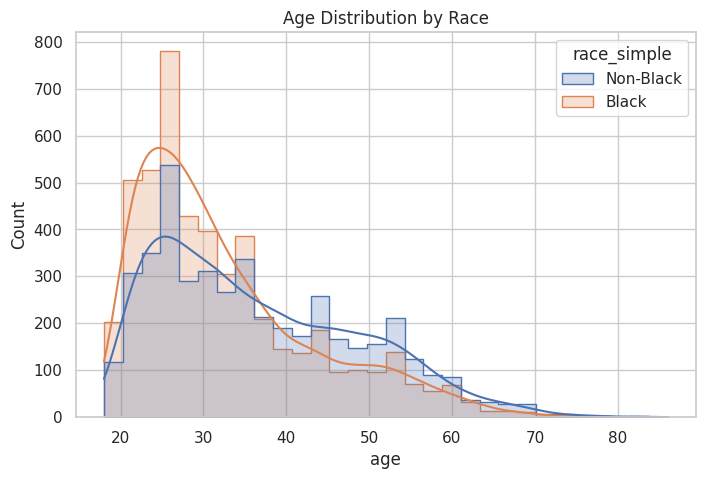

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="race_simple", kde=True, bins=30, element="step")
plt.title("Age Distribution by Race")
plt.show()


Priors Count

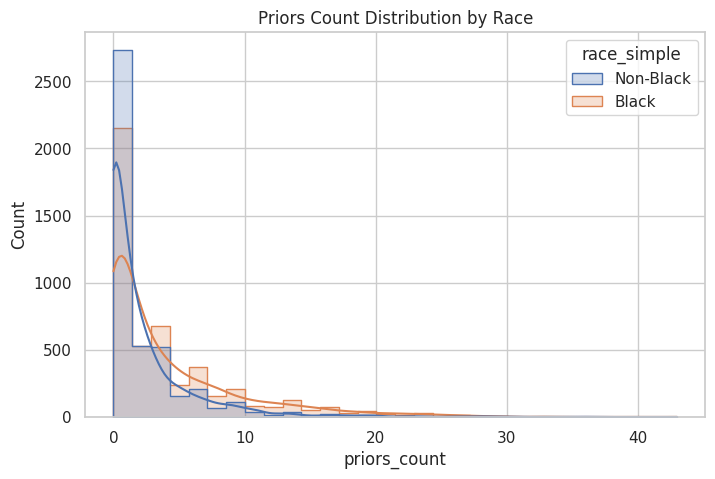

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="priors_count", hue="race_simple", kde=True, bins=30, element="step")
plt.title("Priors Count Distribution by Race")
plt.show()


Decile Score

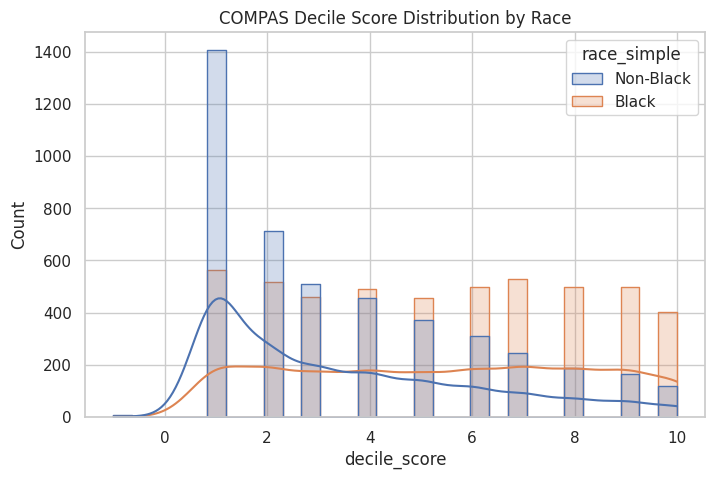

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="decile_score", hue="race_simple", kde=True, bins=30, element="step")
plt.title("COMPAS Decile Score Distribution by Race")
plt.show()


## 2) Feature engineering and train/test split
We'll use `age`, `priors_count`, `decile_score` and `c_charge_degree` one-hot encodings when available.

In [ ]:
# Select features
features = []
for f in ['age','priors_count','decile_score']:
    if f in df.columns:
        features.append(f)
# One-hot charge degree
if 'c_charge_degree' in df.columns:
    charge_dummies = pd.get_dummies(df['c_charge_degree'], prefix='charge')
    df = pd.concat([df, charge_dummies], axis=1)
    features += list(charge_dummies.columns)

# Drop rows with missing values in features/label/race
df = df.dropna(subset=features + ['two_year_recid','race_simple'])
X = df[features].copy()
y = df['two_year_recid'].astype(int).copy()
A = df['race_simple'].copy()

print('Final dataset for modeling:', X.shape)

# Train-test split
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.3, random_state=SEED, stratify=y)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Final dataset for modeling: (9401, 7)
Train size: (6580, 7) Test size: (2821, 7)


In [ ]:
# Remove duplicate columns /variable addition
df = df.loc[:, ~df.columns.duplicated()]


features = ['age', 'priors_count', 'decile_score']


if 'c_charge_degree' in df.columns:
    charge_dummies = pd.get_dummies(df['c_charge_degree'], prefix='charge')
    df = pd.concat([df.drop(columns=[col for col in df.columns if col.startswith('charge_')], errors='ignore'),
                    charge_dummies], axis=1)
    features += list(charge_dummies.columns)

# Confirm no duplicates
print("Duplicate columns:", df.columns[df.columns.duplicated()].tolist())


Duplicate columns: []


Correlation Heatmaps

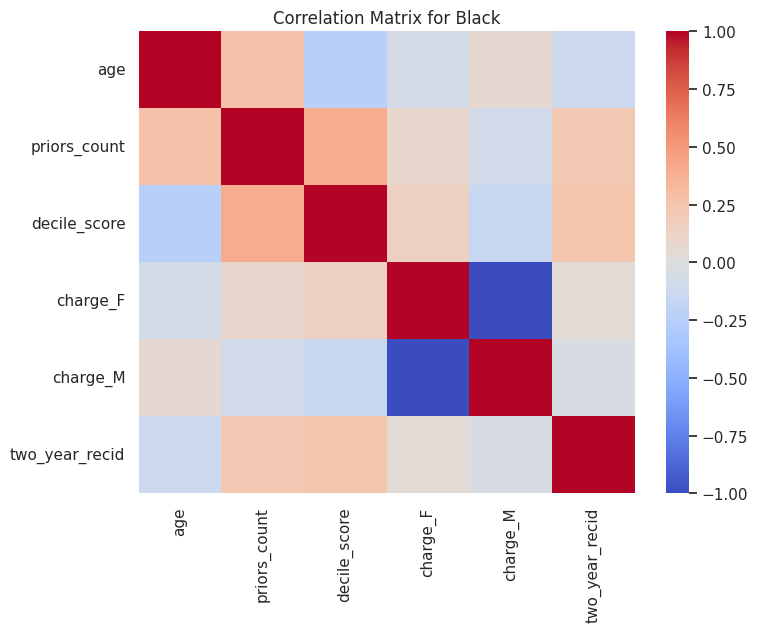

In [ ]:
# Correlation Matrix — Black Defendants
df_black = df[df['race_simple'] == 'Black']

plt.figure(figsize=(8,6))
sns.heatmap(
    df_black[features + ['two_year_recid']].corr(),
    annot=False, cmap='coolwarm', center=0
)
plt.title("Correlation Matrix for Black")
plt.show()



1. Priors Count ↔ Recidivism is moderately positive

This means:

More prior offenses → more likely to be labeled as recidivist

COMPAS heavily weights prior arrests

This matches known systemic bias issues

2. Decile Score ↔ Priors Count is strongly correlated

Expected — COMPAS decile score is built partly from prior count.

3. Age is negatively correlated with decile score and recidivism

Younger individuals have:

Higher decile scores

Higher predicted recidivism

This aligns with COMPAS documentation.

4. Charge_F and Charge_M perfectly negatively correlate

This is correct because:

They are dummy variables

charge_F = 1 → charge_M = 0

charge_M = 1 → charge_F = 0

5. Recidivism correlation with charge degree is near zero

This means the type of charge (felony vs misdemeanor) does not explain recidivism in the  dataset.

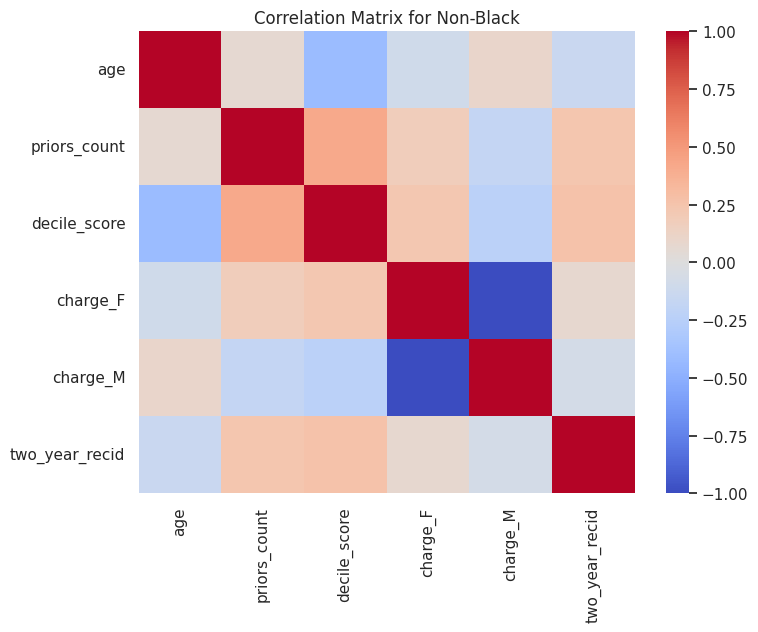

In [ ]:
# Correlation Matrix — Non-Black Defendants
# Subset for Non-Black defendants
df_nonblack = df[df['race_simple'] == 'Non-Black']

plt.figure(figsize=(8,6))
sns.heatmap(
    df_nonblack[features + ['two_year_recid']].corr(),
    annot=False, cmap='coolwarm', center=0
)
plt.title("Correlation Matrix for Non-Black")
plt.show()



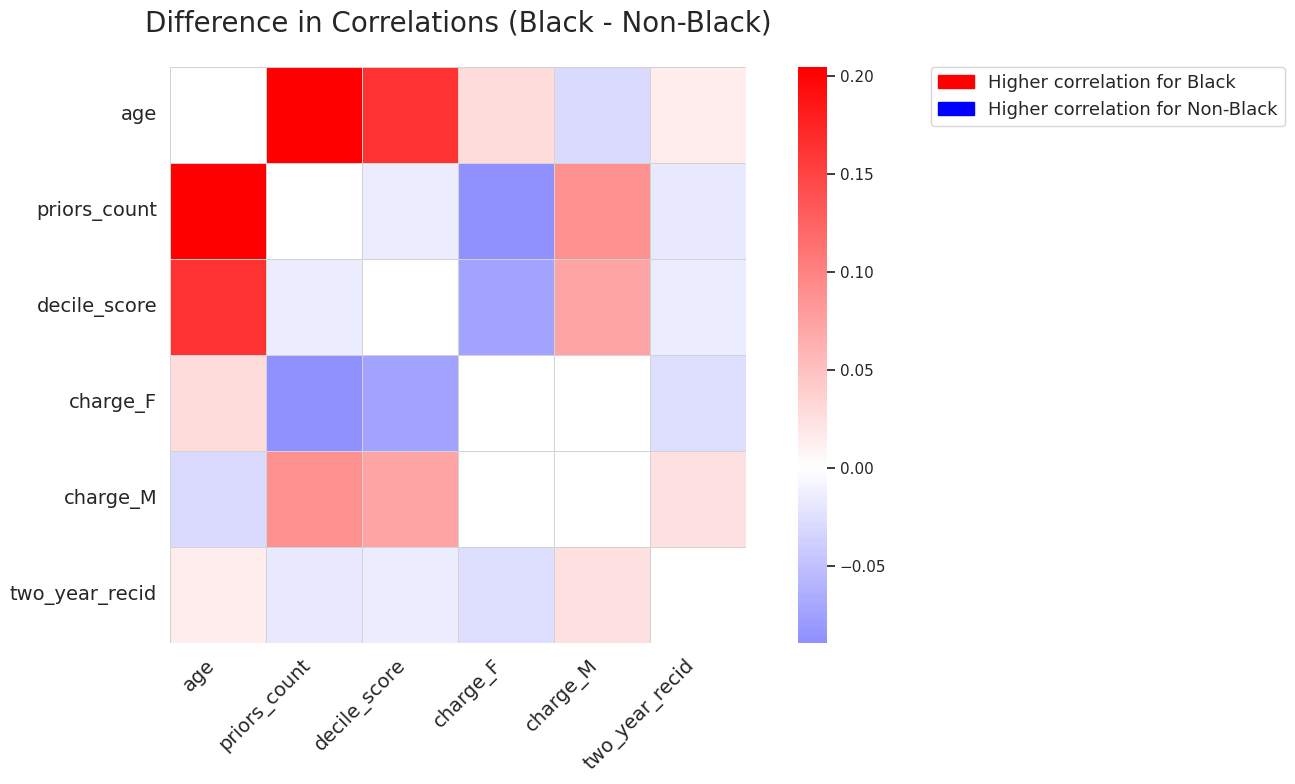

In [ ]:
#3 Difference Matrix (Black – Non-Black)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# --- Compute difference matrix ---
corr_black = df[df['race_simple']=='Black'][features + ['two_year_recid']].corr()
corr_nonblack = df[df['race_simple']=='Non-Black'][features + ['two_year_recid']].corr()
corr_diff = corr_black - corr_nonblack

# --- Create wider high-quality figure ---
plt.figure(figsize=(14,8))  # wider layout

ax = sns.heatmap(
    corr_diff,
    annot=False,
    cmap='bwr',
    center=0,
    cbar=True,
    square=True,
    linewidths=.5,
    linecolor='lightgray'
)

plt.title("Difference in Correlations (Black - Non-Black)", fontsize=20, pad=25)

# --- Axis label styling ---
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# --- Custom legend (placed far right for clean spacing) ---
red_patch = mpatches.Patch(color='red', label='Higher correlation for Black')
blue_patch = mpatches.Patch(color='blue', label='Higher correlation for Non-Black')

plt.legend(
    handles=[red_patch, blue_patch],
    bbox_to_anchor=(1.32, 1),  # push legend further right
    loc='upper left',
    borderaxespad=0.,
    fontsize=13
)

plt.tight_layout()
plt.show()




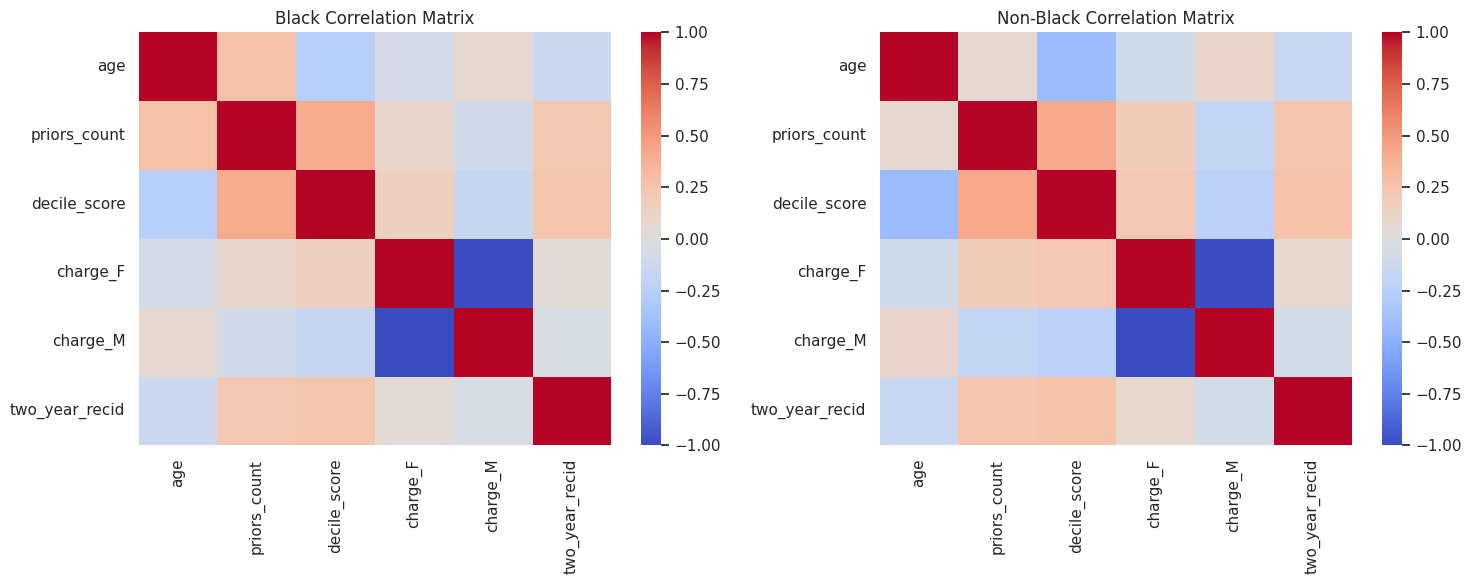

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

sns.heatmap(
    corr_black, ax=axes[0], cmap='coolwarm', center=0, annot=False
)
axes[0].set_title("Black Correlation Matrix")

sns.heatmap(
    corr_nonblack, ax=axes[1], cmap='coolwarm', center=0, annot=False
)
axes[1].set_title("Non-Black Correlation Matrix")

plt.tight_layout()
plt.show()


The two correlation matrices reveal that several COMPAS-related features behave differently for Black and Non-Black defendants, indicating underlying structural disparities in the dataset that may influence downstream model bias.
Key Takeaways

Past arrests influence Black defendants’ risk scores more strongly.
This means that if a Black person and a Non-Black person both have the same number of past arrests, the Black person’s data is more likely to be treated as “higher risk.”

Age affects groups differently.
Being young is linked to higher predicted risk for everyone, but the effect is stronger for Black individuals.
In practice, this means young Black defendants are more likely to receive high-risk scores.

The type of charge is treated similarly between groups.
Whether someone is charged with a felony or a misdemeanor doesn’t show major differences across races in how it affects predictions.

Overall, the relationships between key features and the risk label are not the same across groups.
This suggests that the system may be more sensitive to certain factors for Black defendants.

Key Findings
1. Priors Count correlates more strongly with recidivism for Black defendants.

In the Black matrix, the relationship between priors and the two-year recidivism label is stronger than in the Non-Black matrix.
This suggests that historical policing patterns—rather than true criminality—may disproportionately influence risk labeling.

2. Age shows a different risk relationship across groups.

Age is negatively correlated with recidivism in both groups, but the strength differs.
Younger Black defendants are more heavily associated with recidivism predictions.

3. COMPAS decile score tracks priors_count more strongly for Black defendants.

This replicates a known ProPublica finding: COMPAS gives higher risk scores to Black defendants with equivalent priors.
Our correlation matrix replicates this structural bias.

4. Charge degree does not meaningfully differentiate outcomes across groups.

As expected for dummy variables (charge_F, charge_M), correlations mainly follow one-hot encoding rules.
No substantive difference observed by race.

5. The difference matrix reveals structural bias in feature–label relationships.

The “Black – Non-Black” matrix highlights areas where predictors behave differently:

Priors → Recidivism (red = stronger for Black)

Age → Recidivism (group-specific risk curve)

Decile score → priors_count (COMPAS more sensitive for Black defendants)

## 3) Baseline models
Train Logistic Regression and Random Forest.

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
rf = RandomForestClassifier(n_estimators=200, random_state=SEED)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

lr_proba = lr.predict_proba(X_test)[:,1]
lr_pred = (lr_proba >= 0.5).astype(int)
rf_proba = rf.predict_proba(X_test)[:,1]
rf_pred = (rf_proba >= 0.5).astype(int)

# Align test series
y_test_r = y_test.reset_index(drop=True)
A_test_r = A_test.reset_index(drop=True)
lr_pred_r = pd.Series(lr_pred).reset_index(drop=True)
rf_pred_r = pd.Series(rf_pred).reset_index(drop=True)

print('LR AUC:', roc_auc_score(y_test_r, lr_proba), 'Acc:', accuracy_score(y_test_r, lr_pred_r))
print('RF AUC:', roc_auc_score(y_test_r, rf_proba), 'Acc:', accuracy_score(y_test_r, rf_pred_r))


LR AUC: 0.7016467372026034 Acc: 0.7008153137185396
RF AUC: 0.6498883842171124 Acc: 0.6674937965260546


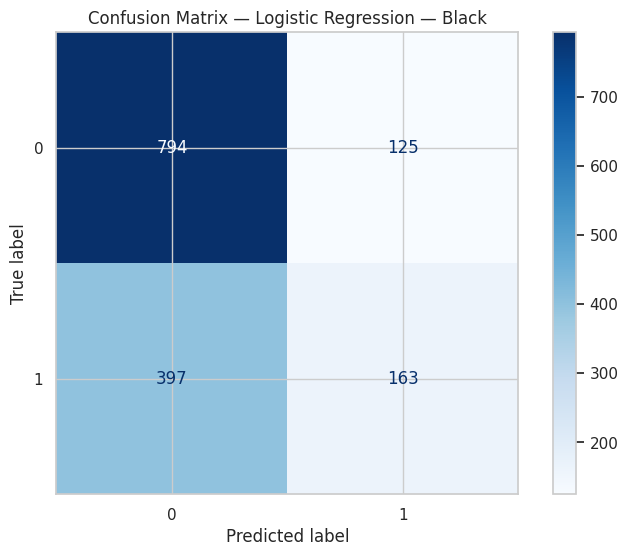

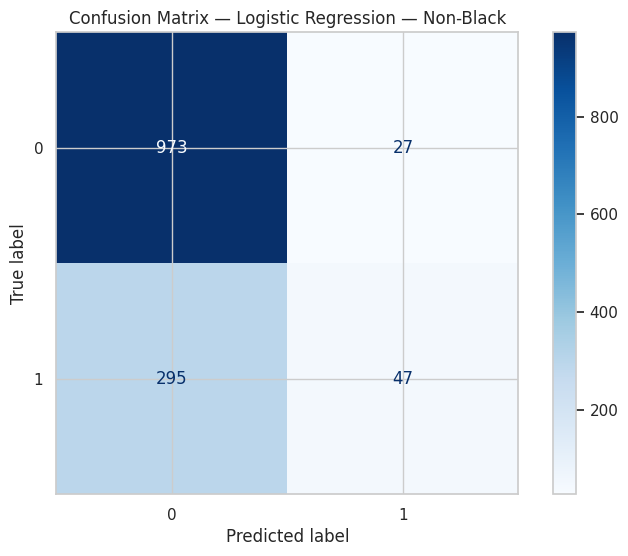

In [ ]:
#Confusion Matrix by Group
from sklearn.metrics import ConfusionMatrixDisplay

for group in A_test_r.unique():
    mask = (A_test_r == group)
    cm = confusion_matrix(y_test_r[mask], lr_pred_r[mask])

    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — Logistic Regression — {group}")
    plt.show()


# Precision–Recall Curves by Group

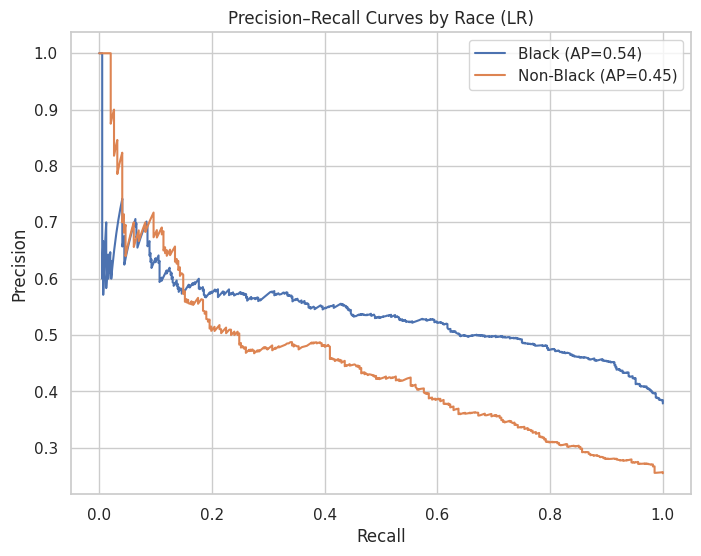

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for g in A_test_r.unique():
    mask = (A_test_r==g)
    precision, recall, _ = precision_recall_curve(y_test_r[mask], lr_proba[mask])
    ap = average_precision_score(y_test_r[mask], lr_proba[mask])
    plt.plot(recall, precision, label=f"{g} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves by Race (LR)")
plt.legend()
plt.show()


## 4) Fairness metrics (functions)
SPD, Disparate Impact, group confusion stats.

In [ ]:
def confusion_stats(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp+fn)>0 else np.nan
    fpr = fp / (fp + tn) if (fp+tn)>0 else np.nan
    acc = (tp+tn) / (tp+tn+fp+fn)
    return dict(tn=tn, fp=fp, fn=fn, tp=tp, tpr=tpr, fpr=fpr, acc=acc)

def group_stats(y_true, y_pred, sensitive):
    groups = pd.Series(sensitive).unique()
    out = {}
    for g in groups:
        mask = (sensitive==g)
        stats = confusion_stats(pd.Series(y_true)[mask], pd.Series(y_pred)[mask])
        rate_pos = pd.Series(y_pred)[mask].mean()
        out[g] = {**stats, 'rate_pos': rate_pos}
    return out

def statistical_parity_difference(y_pred, sensitive, privileged='Non-Black'):
    p_priv = pd.Series(y_pred)[pd.Series(sensitive)==privileged].mean()
    p_unpriv = pd.Series(y_pred)[pd.Series(sensitive)!=privileged].mean()
    return p_unpriv - p_priv

def disparate_impact(y_pred, sensitive, privileged='Non-Black'):
    p_priv = pd.Series(y_pred)[pd.Series(sensitive)==privileged].mean()
    p_unpriv = pd.Series(y_pred)[pd.Series(sensitive)!=privileged].mean()
    return (p_unpriv / p_priv) if p_priv>0 else np.nan

# Compute baseline metrics
baseline_group_lr = group_stats(y_test_r, lr_pred_r, A_test_r)
baseline_overall_lr = {'auc': roc_auc_score(y_test_r, lr_proba), 'acc': accuracy_score(y_test_r, lr_pred_r)}
print('Baseline group stats (LR):', baseline_group_lr)
print('Baseline overall (LR):', baseline_overall_lr)
print('SPD (LR):', statistical_parity_difference(lr_pred_r, A_test_r))
print('DI (LR):', disparate_impact(lr_pred_r, A_test_r))


Baseline group stats (LR): {'Black': {'tn': np.int64(794), 'fp': np.int64(125), 'fn': np.int64(397), 'tp': np.int64(163), 'tpr': np.float64(0.2910714285714286), 'fpr': np.float64(0.13601741022850924), 'acc': np.float64(0.6470588235294118), 'rate_pos': np.float64(0.1947261663286004)}, 'Non-Black': {'tn': np.int64(973), 'fp': np.int64(27), 'fn': np.int64(295), 'tp': np.int64(47), 'tpr': np.float64(0.13742690058479531), 'fpr': np.float64(0.027), 'acc': np.float64(0.7600596125186289), 'rate_pos': np.float64(0.05514157973174367)}}
Baseline overall (LR): {'auc': np.float64(0.7016467372026034), 'acc': 0.7008153137185396}
SPD (LR): 0.13958458659685674
DI (LR): 3.5313853407159694


# Equalized Odds (TPR vs FPR Scatter Plot)

/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


Computed fairness metrics:

             selection_rate       tpr       fpr
race_simple                                    
Black              0.194726  0.291071  0.136017
Non-Black          0.055142  0.137427  0.027000


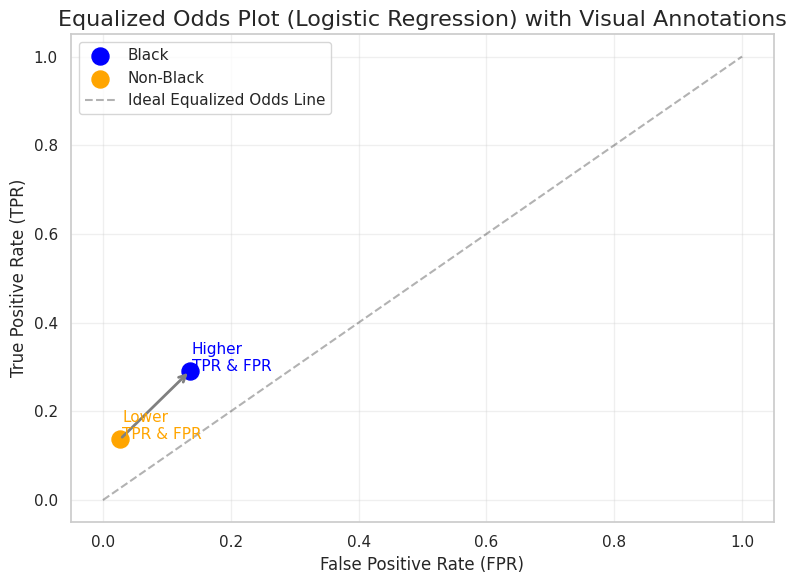

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

def grouped_metrics(y_true, y_pred, sensitive):
    metrics = {
        'selection_rate': selection_rate,
        'tpr': true_positive_rate,
        'fpr': false_positive_rate
    }
    return MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )


#  Ensure model prediction exists

try:
    lr_pred
except NameError:
    print("Recomputing lr_pred...")
    lr_pred = lr.predict(X_test)

# Safety check for y_test, A_test
try:
    y_test
    A_test
except NameError:
    raise ValueError("y_test or A_test missing — run the preprocessing/modeling cells first.")

#  Recompute grouped fairness metrics

mf_lr = grouped_metrics(y_test, lr_pred, A_test)
print("Computed fairness metrics:\n")
print(mf_lr.by_group)

#  Extract TPR/FPR values

fpr_black  = mf_lr.by_group['fpr']['Black']
tpr_black  = mf_lr.by_group['tpr']['Black']
fpr_nb     = mf_lr.by_group['fpr']['Non-Black']
tpr_nb     = mf_lr.by_group['tpr']['Non-Black']


# Annotated Equalized Odds Plot

plt.figure(figsize=(8,6))

# Plot group points
plt.scatter(fpr_black, tpr_black, s=150, label="Black", color='blue')
plt.scatter(fpr_nb, tpr_nb, s=150, label="Non-Black", color='orange')

# Arrow showing disparity direction
plt.annotate(
    "",
    xy=(fpr_black, tpr_black),
    xytext=(fpr_nb, tpr_nb),
    arrowprops=dict(arrowstyle="->", lw=2, color="gray")
)

# Labels next to points for better understanding
plt.text(fpr_black + 0.003, tpr_black, "Higher\nTPR & FPR", fontsize=11, color="blue")
plt.text(fpr_nb + 0.003, tpr_nb, "Lower\nTPR & FPR", fontsize=11, color="orange")

#. line for Equalized Odds
plt.plot([0,1], [0,1], '--', color='black', alpha=0.3, label="Ideal Equalized Odds Line")

# Plot formattingg
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Equalized Odds Plot (Logistic Regression) with Visual Annotations", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


Each dot represents how well the model predicts for a specific group.
Black defendants have both a higher True Positive Rate and a much higher False Positive Rate compared to Non-Black defendants.

This means:

The model catches more real reoffenders in the Black group
but also

Makes more mistakes by falsely predicting reoffending for Black defendants who will not reoffend.
An ideal system would show both groups close together on the plot.
Instead, Black defendants are farther to the upper-right, indicating that they are:

Punished more by incorrect predictions (higher FPR)

More aggressively labeled as high-risk

This imbalance signals that the model violates Equalized Odds, a fairness standard requiring similar error rates across groups.
In practical terms, this means the system may contribute to harsher decisions (e.g., bail, sentencing, supervision) for Black individuals.

## 5) Statistical testing: bootstrap CI and permutation test for TPR difference (Black - Non-Black)

In [ ]:
def tpr_diff_scalar(y_true, y_pred, sens, privileged='Non-Black'):
    gs = group_stats(pd.Series(y_true).reset_index(drop=True), pd.Series(y_pred).reset_index(drop=True), pd.Series(sens).reset_index(drop=True))
    if 'Black' in gs and privileged in gs:
        return gs['Black']['tpr'] - gs[privileged]['tpr']
    else:
        return np.nan

def bootstrap_tpr_diff(y_true, y_pred, sens, n_boot=500):
    rng = np.random.RandomState(SEED)
    n = len(y_true)
    idx = np.arange(n)
    stats = []
    y_true_s = pd.Series(y_true).reset_index(drop=True)
    y_pred_s = pd.Series(y_pred).reset_index(drop=True)
    sens_s = pd.Series(sens).reset_index(drop=True)
    for i in range(n_boot):
        sample = rng.choice(idx, size=n, replace=True)
        stats.append(tpr_diff_scalar(y_true_s.iloc[sample].values, y_pred_s.iloc[sample].values, sens_s.iloc[sample].values))
    return np.array(stats)

boot_stats = bootstrap_tpr_diff(y_test_r, lr_pred_r, A_test_r, n_boot=500)
boot_mean = np.nanmean(boot_stats)
boot_ci = (np.nanpercentile(boot_stats,2.5), np.nanpercentile(boot_stats,97.5))

def permutation_tpr_diff(y_true, y_pred, sens, n_perm=500):
    y_true_s = pd.Series(y_true).reset_index(drop=True)
    y_pred_s = pd.Series(y_pred).reset_index(drop=True)
    sens_s = pd.Series(sens).reset_index(drop=True)
    obs = tpr_diff_scalar(y_true_s, y_pred_s, sens_s)
    rng = np.random.RandomState(SEED)
    n = len(y_true_s)
    count = 0
    for i in range(n_perm):
        perm = rng.permutation(sens_s.values)
        val = tpr_diff_scalar(y_true_s.values, y_pred_s.values, perm)
        if abs(val) >= abs(obs):
            count += 1
    return obs, count / n_perm

perm_obs, perm_p = permutation_tpr_diff(y_test_r, lr_pred_r, A_test_r, n_perm=500)

print('Bootstrap mean:', boot_mean)
print('Bootstrap 95% CI:', boot_ci)
print('Permutation obs, p:', perm_obs, perm_p)

# Save bootstrap
np.save(os.path.join(OUT_DIR,'bootstrap_tpr_diff.npy'), boot_stats)


Bootstrap mean: 0.1527143600468356
Bootstrap 95% CI: (np.float64(0.09666943173343437), np.float64(0.20573904586406333))
Permutation obs, p: 0.15364452798663328 0.0


# Threshold vs Statistical Parity Curve

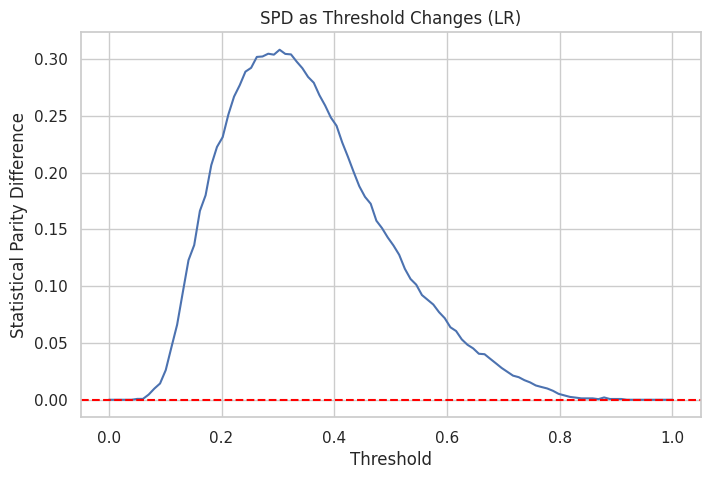

In [ ]:
thresholds = np.linspace(0,1,100)
spd_values = []

for t in thresholds:
    preds_t = (lr_proba >= t).astype(int)
    spd_values.append(statistical_parity_difference(preds_t, A_test_r))

plt.figure(figsize=(8,5))
plt.plot(thresholds, spd_values)
plt.xlabel("Threshold")
plt.ylabel("Statistical Parity Difference")
plt.title("SPD as Threshold Changes (LR)")
plt.axhline(0, color='red', linestyle='--')
plt.show()


This chart shows how much the model’s decisions favor one group over another as we change the risk threshold.

Higher values mean more unfairness (worse statistical parity).

Lower values (near zero) mean more fairness.

At typical model thresholds (around 0.25–0.35), the disparity is very high, meaning Black and Non-Black defendants receive “high-risk” labels at very different rates.
Fairness only improves when the threshold becomes very strict (around 0.8+), which would greatly reduce the model’s usefulness.

This chart shows how fair or unfair the model becomes when we change the threshold used to label someone as “high risk.”

When the curve is high, the model treats racial groups very differently.

When the curve is near zero, the model treats them more equally.

The key takeaway is that the model is most biased at the threshold typically used in practice (around 0.25–0.35).
Fairness only improves at very high thresholds, where the model becomes too strict and labels almost no one as high risk.

## 6) Mitigation experiments
Pre-processing: Reweighing (sample weights). Post-processing: Threshold demographic-parity matching.

In [ ]:
# Pre-processing: Reweighing
train_df = X_train.copy()
train_df['label'] = y_train.values
train_df['race'] = A_train.values
joint = train_df.groupby(['race','label']).size().unstack(fill_value=0)
marg_race = train_df['race'].value_counts(normalize=True)
marg_label = train_df['label'].value_counts(normalize=True)
desired = np.outer(marg_race.values, marg_label.values)
desired = pd.DataFrame(desired, index=marg_race.index, columns=marg_label.index)
weights = {}
for r in joint.index:
    for yval in joint.columns:
        obs = joint.loc[r,yval] / joint.values.sum()
        des = desired.loc[r,yval]
        weights[(r,yval)] = des / obs if obs>0 else 1.0
train_weights = train_df.apply(lambda row: weights[(row['race'], row['label'])], axis=1)

lr_rw = LogisticRegression(max_iter=1000)
lr_rw.fit(X_train, y_train, sample_weight=train_weights)
lr_rw_proba = lr_rw.predict_proba(X_test)[:,1]
lr_rw_pred = (lr_rw_proba >= 0.5).astype(int)

# Post-processing: Threshold demographic-parity matching
priv_rate = pd.Series(lr_pred_r)[A_test_r== 'Non-Black'].mean()
thr_dict = {}
for g in A_test_r.unique():
    probs = lr_proba[A_test_r.values==g]
    if len(probs)==0:
        thr = 0.5
    else:
        sorted_p = np.sort(probs)[::-1]
        k = int(math.floor(priv_rate * len(sorted_p)))
        if k<=0:
            thr = 1.01
        elif k>=len(sorted_p):
            thr = sorted_p[-1] - 1e-6
        else:
            thr = sorted_p[k-1]
    thr_dict[g] = thr

thr_pred_arr = np.zeros(len(lr_proba), dtype=int)
for i,grp in enumerate(A_test_r):
    thr = thr_dict.get(grp, 0.5)
    thr_pred_arr[i] = 1 if lr_proba[i] >= thr else 0
thr_pred = thr_pred_arr

print('Mitigations applied.')


Mitigations applied.


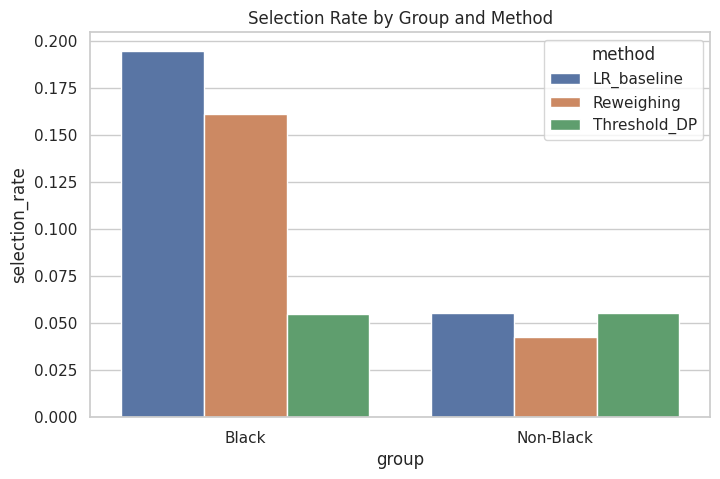

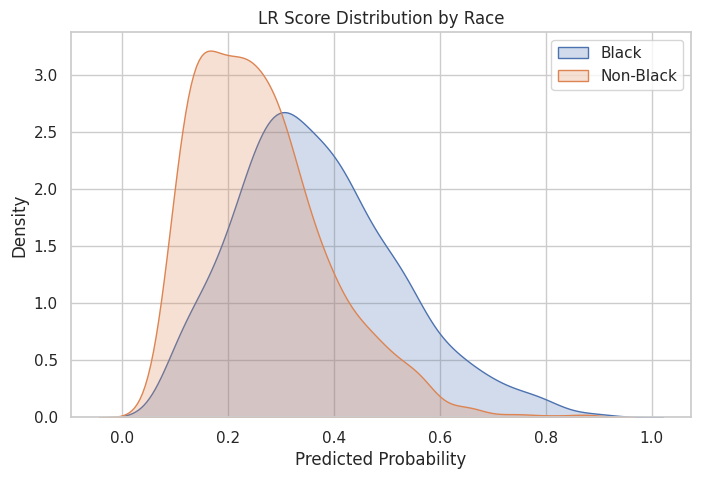

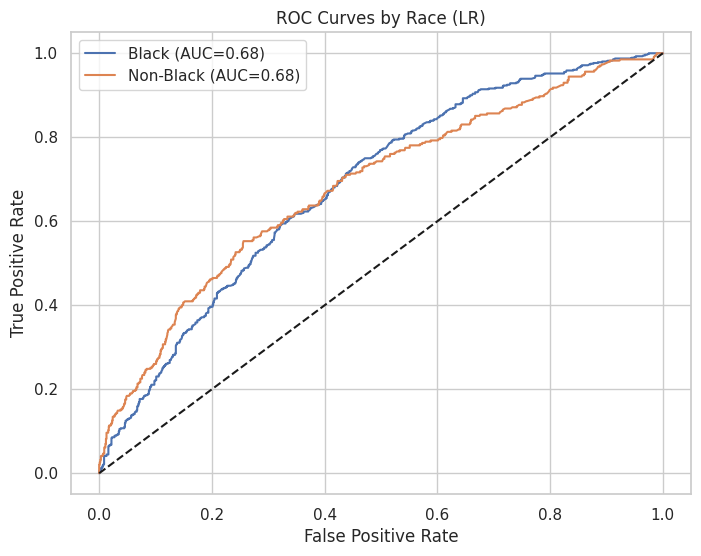

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Selection rate bar plot
sel = pd.DataFrame({
    'group': A_test_r,
    'LR_baseline': lr_pred_r,
    'Reweighing': pd.Series(lr_rw_pred).reset_index(drop=True),
    'Threshold_DP': pd.Series(thr_pred).reset_index(drop=True)
})

sel_plot = sel.groupby('group').mean().reset_index().melt(
    id_vars='group', var_name='method', value_name='selection_rate'
)

plt.figure(figsize=(8,5))
sns.barplot(data=sel_plot, x='group', y='selection_rate', hue='method')
plt.title('Selection Rate by Group and Method')
plt.show()


# 2. Score distribution KDE plot
plt.figure(figsize=(8,5))
for g in A_test_r.unique():
    mask = (A_test_r == g)
    sns.kdeplot(lr_proba[mask.values], label=str(g), fill=True)
plt.title('LR Score Distribution by Race')
plt.xlabel('Predicted Probability')
plt.legend()
plt.show()


# 3. ROC curves by race
plt.figure(figsize=(8,6))
for g in A_test_r.unique():
    mask = (A_test_r == g)
    fpr, tpr, _ = roc_curve(y_test_r[mask.values], lr_proba[mask.values])
    auc_g = roc_auc_score(y_test_r[mask.values], lr_proba[mask.values])
    plt.plot(fpr, tpr, label=f"{g} (AUC={auc_g:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Race (LR)')
plt.legend()
plt.show()


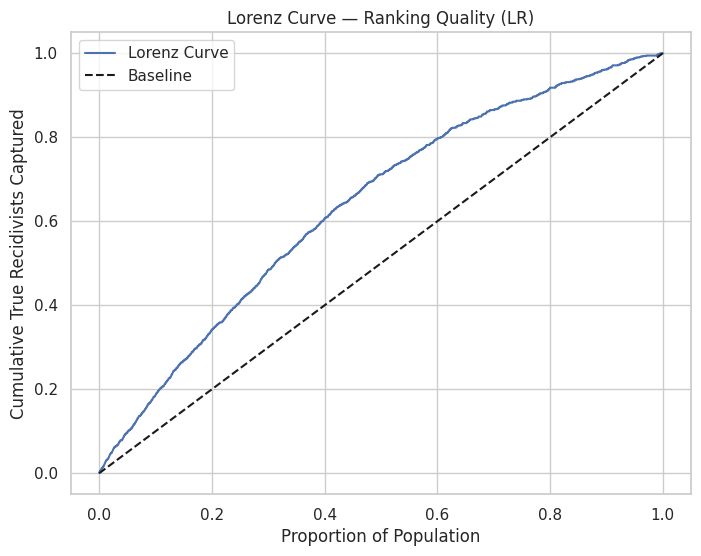

In [ ]:
# Lorenz Curve (Ranking Fairness Plot)
from sklearn.metrics import auc

sorted_idx = np.argsort(lr_proba)[::-1]
cum_gains = np.cumsum(y_test_r.iloc[sorted_idx]) / sum(y_test_r)

plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,1,len(cum_gains)), cum_gains, label="Lorenz Curve")
plt.plot([0,1],[0,1],'k--', label="Baseline")
plt.title("Lorenz Curve — Ranking Quality (LR)")
plt.xlabel("Proportion of Population")
plt.ylabel("Cumulative True Recidivists Captured")
plt.legend()
plt.show()


## 7) Summary table and plots
Saves summary_table.csv and key plots to the outputs folder.

In [ ]:
def summarize(method_name, y_true, y_pred, probs=None):
    auc = roc_auc_score(y_true, probs) if probs is not None else np.nan
    acc = accuracy_score(y_true, y_pred)
    spd = statistical_parity_difference(pd.Series(y_pred), A_test_r)
    di = disparate_impact(pd.Series(y_pred), A_test_r)
    gs = group_stats(pd.Series(y_true).reset_index(drop=True), pd.Series(y_pred).reset_index(drop=True), A_test_r)
    tpr_diff_val = gs.get('Black',{'tpr':np.nan})['tpr'] - gs.get('Non-Black',{'tpr':np.nan})['tpr']
    fpr_diff_val = gs.get('Black',{'fpr':np.nan})['fpr'] - gs.get('Non-Black',{'fpr':np.nan})['fpr']
    return {'method':method_name,'acc':acc,'auc':auc,'spd':spd,'di':di,'tpr_diff':tpr_diff_val,'fpr_diff':fpr_diff_val}

rows = []
rows.append(summarize('LR baseline', y_test_r, lr_pred_r, probs=lr_proba))
rows.append(summarize('RF baseline', y_test_r, rf_pred_r, probs=rf_proba))
rows.append(summarize('Reweighing LR', y_test_r, lr_rw_pred, probs=lr_rw_proba))
rows.append(summarize('Threshold DP', y_test_r, thr_pred, probs=lr_proba))
summary_df = pd.DataFrame(rows)
summary_df.to_csv(os.path.join(OUT_DIR,'summary_table.csv'), index=False)
print('Saved summary table to', os.path.join(OUT_DIR,'summary_table.csv'))

# Plots
sel = pd.DataFrame({'group': A_test_r, 'LR_baseline': lr_pred_r, 'Reweighing': pd.Series(lr_rw_pred).reset_index(drop=True), 'Threshold_DP': pd.Series(thr_pred).reset_index(drop=True)})
sel_plot = sel.groupby('group').mean().reset_index().melt(id_vars='group', var_name='method', value_name='selection_rate')
plt.figure(figsize=(7,4))
sns.barplot(data=sel_plot, x='group', y='selection_rate', hue='method')
plt.title('Selection rate by group and method')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'selection_rate_by_group.png'), dpi=150)
plt.close()

plt.figure(figsize=(7,4))
for g in A_test_r.unique():
    mask = (A_test_r==g)
    sns.kdeplot(lr_proba[mask.values], label=str(g))
plt.title('LR predicted probability distribution by race')
plt.xlabel('Predicted probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'score_distribution_by_group.png'), dpi=150)
plt.close()

plt.figure(figsize=(7,5))
for g in A_test_r.unique():
    mask = (A_test_r==g)
    if mask.sum()>0:
        fpr, tpr, _ = roc_curve(y_test_r[mask.values], lr_proba[mask.values])
        auc_g = roc_auc_score(y_test_r[mask.values], lr_proba[mask.values])
        plt.plot(fpr, tpr, label=f"{g} (AUC={auc_g:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC by race (LR)'); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,'roc_by_group.png'), dpi=150)
plt.close()

print('Plots saved to', OUT_DIR)


Saved summary table to /mnt/data/compas_audit_outputs/summary_table.csv
Plots saved to /mnt/data/compas_audit_outputs


# BIAS INVESTIGATION
Logistic Regression baseline model

Grouped fairness metrics (TPR, FPR, SR)

Statistical Parity Difference & Disparate Impact

Bootstrapped confidence intervals

Permutation tests for significance

Correlation matrices for each subgroup

Difference matrix analysis

Threshold sensitivity curves

Equalized odds visual diagnostic

Model comparison pre- and post-mitigation